In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from function_interpolate_1theodolite import process_lidar_1theodolite
from function_interpolate_2theodolites import process_lidar_2theodolite
import seaborn as sns
from function_calculation_altitude_from_wxt import process_altitude

## Create combined Lidar files

In [25]:
# create a combined file for Lidar data on 2025-08-27
'''
files = ["20250827_080000.nc", "20250827_090000.nc", "20250827_100000.nc", "20250827_110000.nc"]

folder = "Data_Lidar/20250827"
file_paths = [os.path.join(folder, f) for f in files]

# Öffnen und automatisch entlang der Dimension "time" kombinieren
ds = xr.open_mfdataset(file_paths, combine='by_coords')

# Ergebnis als neues NetCDF speichern
ds.to_netcdf("Data_Lidar/20250827/combined_20250827.nc")
'''

'\nfiles = ["20250827_080000.nc", "20250827_090000.nc", "20250827_100000.nc", "20250827_110000.nc"]\n\nfolder = "Data_Lidar/20250827"\nfile_paths = [os.path.join(folder, f) for f in files]\n\n# Öffnen und automatisch entlang der Dimension "time" kombinieren\nds = xr.open_mfdataset(file_paths, combine=\'by_coords\')\n\n# Ergebnis als neues NetCDF speichern\nds.to_netcdf("Data_Lidar/20250827/combined_20250827.nc")\n'

In [26]:
# create a combined file for Lidar data on 2025-09-01
'''
files = ["20250901_090000.nc", "20250901_100000.nc", "20250901_110000.nc", "20250901_120000.nc", "20250901_130000.nc", "20250901_140000.nc"]

folder = "Data_Lidar/20250901"
file_paths = [os.path.join(folder, f) for f in files]

# Öffnen und automatisch entlang der Dimension "time" kombinieren
ds = xr.open_mfdataset(file_paths, combine='by_coords')

# Ergebnis als neues NetCDF speichern
ds.to_netcdf("Data_Lidar/20250901/combined_20250901.nc")
'''

'\nfiles = ["20250901_090000.nc", "20250901_100000.nc", "20250901_110000.nc", "20250901_120000.nc", "20250901_130000.nc", "20250901_140000.nc"]\n\nfolder = "Data_Lidar/20250901"\nfile_paths = [os.path.join(folder, f) for f in files]\n\n# Öffnen und automatisch entlang der Dimension "time" kombinieren\nds = xr.open_mfdataset(file_paths, combine=\'by_coords\')\n\n# Ergebnis als neues NetCDF speichern\nds.to_netcdf("Data_Lidar/20250901/combined_20250901.nc")\n'

In [27]:
# create a combined file for Lidar data on 2025-09-03
'''
files = ["20250903_080000.nc", "20250903_090000.nc", "20250903_100000.nc", "20250903_110000.nc", "20250903_120000.nc", "20250903_130000.nc", "20250903_140000.nc", "20250903_150000.nc"]

folder = "Data_Lidar/20250903"
file_paths = [os.path.join(folder, f) for f in files]

# Öffnen und automatisch entlang der Dimension "time" kombinieren
ds = xr.open_mfdataset(file_paths, combine='by_coords')

# Ergebnis als neues NetCDF speichern
ds.to_netcdf("Data_Lidar/20250903/combined_20250903.nc")
'''

'\nfiles = ["20250903_080000.nc", "20250903_090000.nc", "20250903_100000.nc", "20250903_110000.nc", "20250903_120000.nc", "20250903_130000.nc", "20250903_140000.nc", "20250903_150000.nc"]\n\nfolder = "Data_Lidar/20250903"\nfile_paths = [os.path.join(folder, f) for f in files]\n\n# Öffnen und automatisch entlang der Dimension "time" kombinieren\nds = xr.open_mfdataset(file_paths, combine=\'by_coords\')\n\n# Ergebnis als neues NetCDF speichern\nds.to_netcdf("Data_Lidar/20250903/combined_20250903.nc")\n'

## Calculate altitude of kite

In [28]:
# function to calculate the height from the pressure, with hydrostatic approximation
def height_from_pressure(p2, p1=1007,rho=1.15, g=9.81):
    dp = p1 - p2
    dz = dp / (rho * g)
    return dz

In [29]:
# 2025-08-27
'''
process_altitude(
    date_str="2025-08-27",
    ptu_file="Data_Radiosonde/PtuResults.xlsx",
    wxt_file="Data_WXT/20250827.txt",
    lidar_file="Data_Lidar/20250827/combined_20250827.nc",
    output_csv="Data_Altitude/20250827_altitude_kite_from_wxt_funct.csv"
)
'''

'\nprocess_altitude(\n    date_str="2025-08-27",\n    ptu_file="Data_Radiosonde/PtuResults.xlsx",\n    wxt_file="Data_WXT/20250827.txt",\n    lidar_file="Data_Lidar/20250827/combined_20250827.nc",\n    output_csv="Data_Altitude/20250827_altitude_kite_from_wxt_funct.csv"\n)\n'

In [30]:
# 2025-08-29
'''
ds_lidar_cut_0829, theo_interp_0829 = process_lidar_2theodolite(
    lidar_file="Data_Lidar/20250829/combined_20250829.nc",
    theoRot_file="Data_Theodolite/TheoRot_20250829_123352.txt",
    theoGelb_file="Data_Theodolite/TheoGelb_20250829_124013.txt",
    date_str="2025-08-29",
    start_time_str="08:31:08",
    azimuth_offsetRot= 129.1787,
    azimuth_offsetGelb= 51.8498
)

alt_0829 = np.sin(np.deg2rad(theo_interp_0829['elevation'])) * 87.56
df_alt_cont = pd.DataFrame({
    "time": ds_lidar_cut_0829['time'],
    "altitude": np.array(alt_0829)
})

df_alt_cont.to_csv("Data_Altitude/20250829_altitude_kite_from_tetherlength.csv", index=False)
'''

'\nds_lidar_cut_0829, theo_interp_0829 = process_lidar_2theodolite(\n    lidar_file="Data_Lidar/20250829/combined_20250829.nc",\n    theoRot_file="Data_Theodolite/TheoRot_20250829_123352.txt",\n    theoGelb_file="Data_Theodolite/TheoGelb_20250829_124013.txt",\n    date_str="2025-08-29",\n    start_time_str="08:31:08",\n    azimuth_offsetRot= 129.1787,\n    azimuth_offsetGelb= 51.8498\n)\n\nalt_0829 = np.sin(np.deg2rad(theo_interp_0829[\'elevation\'])) * 87.56\ndf_alt_cont = pd.DataFrame({\n    "time": ds_lidar_cut_0829[\'time\'],\n    "altitude": np.array(alt_0829)\n})\n\ndf_alt_cont.to_csv("Data_Altitude/20250829_altitude_kite_from_tetherlength.csv", index=False)\n'

In [31]:
# 2025-09-01
'''
process_altitude(
    date_str="2025-09-01",
    ptu_file="Data_Radiosonde/20250901/PtuResults.xlsx",
    wxt_file="Data_WXT/20250901.txt",
    lidar_file="Data_Lidar/20250901/combined_20250901.nc",
    output_csv="Data_Altitude/20250901_altitude_kite_from_wxt.csv"
)
'''

'\nprocess_altitude(\n    date_str="2025-09-01",\n    ptu_file="Data_Radiosonde/20250901/PtuResults.xlsx",\n    wxt_file="Data_WXT/20250901.txt",\n    lidar_file="Data_Lidar/20250901/combined_20250901.nc",\n    output_csv="Data_Altitude/20250901_altitude_kite_from_wxt.csv"\n)\n'

In [32]:
# 2025-09-03, 1st period
'''
process_altitude(
    date_str="2025-09-03",
    ptu_file="Data_Radiosonde/20250903/PtuResults_1stperiod.xlsx",
    wxt_file="Data_WXT/20250903.txt",
    lidar_file="Data_Lidar/20250903/combined_20250903.nc",
    output_csv="Data_Altitude/20250903_1stperiod_altitude_kite_from_wxt.csv"
)
'''

'\nprocess_altitude(\n    date_str="2025-09-03",\n    ptu_file="Data_Radiosonde/20250903/PtuResults_1stperiod.xlsx",\n    wxt_file="Data_WXT/20250903.txt",\n    lidar_file="Data_Lidar/20250903/combined_20250903.nc",\n    output_csv="Data_Altitude/20250903_1stperiod_altitude_kite_from_wxt.csv"\n)\n'

In [33]:
# 2025-09-03, 2nd period
'''
process_altitude(
    date_str="2025-09-03",
    ptu_file="Data_Radiosonde/20250903/PtuResults_2ndperiod.xlsx",
    wxt_file="Data_WXT/20250903.txt",
    lidar_file="Data_Lidar/20250903/combined_20250903.nc",
    output_csv="Data_Altitude/20250903_2ndperiod_altitude_kite_from_wxt.csv"
)
'''

'\nprocess_altitude(\n    date_str="2025-09-03",\n    ptu_file="Data_Radiosonde/20250903/PtuResults_2ndperiod.xlsx",\n    wxt_file="Data_WXT/20250903.txt",\n    lidar_file="Data_Lidar/20250903/combined_20250903.nc",\n    output_csv="Data_Altitude/20250903_2ndperiod_altitude_kite_from_wxt.csv"\n)\n'

## Read data

In [34]:
# read data 2025-08-27
ds_lidar_cut, theo_interp = process_lidar_1theodolite(
    lidar_file="Data_Lidar/20250827/20250827_090000.nc",
    theo_file="Data_Theodolite/TheoRot_20250827_150544.txt",
    date_str="2025-08-27",
    start_time_str="09:08:09",
    azimuth_offset= 107.46
)

Metadata: S 25/08/27 09:08:09


In [35]:
# cut out the valid periods for day 2025-08-27
valid1 = datetime(2025, 8, 27, 9, 21, 0)  # 2025-08-27 11:21:00
valid2 = datetime(2025, 8, 27, 9, 39, 0)  # 2025-08-27 11:39:00
valid3 = datetime(2025, 8, 27, 9, 45, 0)  # 2025-08-27 11:45:00
valid4 = datetime(2025, 8, 27, 9, 53, 0)  # 2025-08-27 11:53:00

VEL_27_09_1 = ds_lidar_cut.sel(time=slice(valid1, valid2))
VEL_27_09_2 = ds_lidar_cut.sel(time=slice(valid3, valid4))
theo_27_09_1 = theo_interp.sel(time=slice(valid1, valid2))
theo_27_09_2 = theo_interp.sel(time=slice(valid3, valid4))

In [36]:
# read data 2025-08-29
ds_lidar_cut_0829, theo_interp_0829 = process_lidar_2theodolite(
    lidar_file="Data_Lidar/20250829/combined_20250829.nc",
    theoRot_file="Data_Theodolite/TheoRot_20250829_123352.txt",
    theoGelb_file="Data_Theodolite/TheoGelb_20250829_124013.txt",
    date_str="2025-08-29",
    start_time_str="08:31:08",
    azimuth_offsetRot= 129.1787,
    azimuth_offsetGelb= 51.8498
)

Metadata: S 25/08/29 08:31:09
Metadata: S 25/08/29 08:31:08


In [37]:
# read data 2025-09-01
# STILL ADD THE AZIMUTH CORRECTIONS!!!
ds_lidar_cut_0901_period1, theo_interp_0901_period1 = process_lidar_2theodolite(
    lidar_file="Data_Lidar/20250901/combined_20250901.nc",
    theoRot_file="Data_Theodolite/TheoRot_20250901_1st_period.txt",
    theoGelb_file="Data_Theodolite/TheoGelb_20250901_1st_period.txt",
    date_str="2025-09-01",
    start_time_str="09:03:20",
    azimuth_offsetRot= 0.0,
    azimuth_offsetGelb= 0.0
)
ds_lidar_cut_0901_period2, theo_interp_0901_period2 = process_lidar_2theodolite(
    lidar_file="Data_Lidar/20250901/combined_20250901.nc",
    theoRot_file="Data_Theodolite/TheoRot_20250901_2nd_period.txt",
    theoGelb_file="Data_Theodolite/TheoGelb_20250901_2nd_period.txt",
    date_str="2025-09-01",
    start_time_str="12:17:09",
    azimuth_offsetRot= 0.0,
    azimuth_offsetGelb= 0.0
)

Metadata: S 25/09/01 09:03:20
Metadata: S 25/09/01 09:03:20
Metadata: S 25/09/01 12:17:09
Metadata: S 25/09/01 12:17:08


In [38]:
# read data 2025-09-03
# STILL ADD THE AZIMUTH CORRECTIONS!!!
ds_lidar_cut_0903_period1, theo_interp_0903_period1 = process_lidar_1theodolite(
    lidar_file="Data_Lidar/20250903/combined_20250903.nc",
    theo_file="Data_Theodolite/TheoGelb_20250903_1stperiod.txt",
    date_str="2025-09-03",
    start_time_str="08:48:09",
    azimuth_offset= 0.0
)

ds_lidar_cut_0903_period2, theo_interp_0903_period2 = process_lidar_1theodolite(
    lidar_file="Data_Lidar/20250903/combined_20250903.nc",
    theo_file="Data_Theodolite/TheoGelb_20250903_2ndperiod.txt",
    date_str="2025-09-03",
    start_time_str="12:42:17",
    azimuth_offset= 0.0
)

Metadata: S 25/09/03 08:48:09
Metadata: S 25/09/03 12:42:17


In [39]:
# plot altitude from hydrostatic approximation
'''
fig = plt.figure()
plt.plot(df_ptu[1:3683].index,height_from_pressure(df_ptu['Pressure'][1:3683])*100, '.-',markersize=0.5, label = r'$p_0$ = 1007 hPa')
plt.plot(df_min['Time'][:61],altitude_cont*100, '.-', color='red',label = r'$p_0$ = p(WXT station)')
plt.xlim(df_min['Time'][0], df_min['Time'][61])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.ylim(0,100)
plt.title(r'Kite altitude calculated from hydrostatic equation, 2025-08-27')
plt.ylabel('Altitude above reference level (m)')
plt.xlabel('Time (UTC)')
plt.legend()
plt.show()
fig.savefig('Plots/20250827_Radiosonde_altitude.png', dpi=300)
'''

"\nfig = plt.figure()\nplt.plot(df_ptu[1:3683].index,height_from_pressure(df_ptu['Pressure'][1:3683])*100, '.-',markersize=0.5, label = r'$p_0$ = 1007 hPa')\nplt.plot(df_min['Time'][:61],altitude_cont*100, '.-', color='red',label = r'$p_0$ = p(WXT station)')\nplt.xlim(df_min['Time'][0], df_min['Time'][61])\nplt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))\nplt.ylim(0,100)\nplt.title(r'Kite altitude calculated from hydrostatic equation, 2025-08-27')\nplt.ylabel('Altitude above reference level (m)')\nplt.xlabel('Time (UTC)')\nplt.legend()\nplt.show()\nfig.savefig('Plots/20250827_Radiosonde_altitude.png', dpi=300)\n"

## Combine data

In [40]:
def process_altimeter_lidar(altimeter_csv, lidar_data, valid_periods):
    """
    Schneidet Altimeter-Daten auf gültige Zeitintervalle zu,
    rundet auf nächstgelegene Lidar-Höhenlevel und merged die Daten.

    Parameters:
    -----------
    altimeter_csv : str
        Pfad zur Altimeter-CSV-Datei mit Spalten ["time", "altitude"].
    lidar_data : xarray.Dataset
        Lidar-Dataset mit Dimensionen 'time' x 'height' und Variable 'VEL'.
    valid_periods : list of tuple
        Liste von gültigen Zeitintervallen [(start1, end1), (start2, end2), ...]
        z.B. [(valid1, valid2), (valid3, valid4)]

    Returns:
    --------
    pd.DataFrame
        Merge von Altimeter + Lidar Daten mit Spalten ["time", "altitude", "height", "VEL"].
    """
    # 1) Altimeter-Daten einlesen
    alt_df = pd.read_csv(altimeter_csv, parse_dates=["time"])

    # Filter für alle gültigen Zeitintervalle
    mask = np.zeros(len(alt_df), dtype=bool)
    for start, end in valid_periods:
        mask |= (alt_df['time'] >= start) & (alt_df['time'] <= end)

    alt_df = alt_df.loc[mask]

    # NaN-Werte rausfiltern
    alt_df = alt_df.dropna(subset=["altitude"])

    # -------------------------------
    # 2) Höhenlevels aus Lidar ziehen
    # -------------------------------
    lidar_levels = lidar_data['height'].values

    def nearest_level(h):
        """Finde das nächstgelegene Lidar-Höhenlevel."""
        return lidar_levels[np.argmin(np.abs(lidar_levels - h))]

    alt_df["height"] = alt_df["altitude"].apply(nearest_level)

    # -------------------------------
    # 3) Lidar-Daten in Pandas umwandeln
    # -------------------------------
    vel_df = lidar_data['VEL'].to_dataframe().reset_index()  # ["time", "height", "VEL"]

    # -------------------------------
    # 4) Merge Altimeter + Lidar
    # -------------------------------
    merged = alt_df.merge(vel_df, on=["time", "height"], how="left")

    return merged[["time", "altitude", "height", "VEL"]]

In [41]:
# read altitude data
merged_0827_1 = process_altimeter_lidar('Data_Altitude/20250827_altitude_kite_from_wxt.csv', VEL_27_09_1, [(valid1, valid2)])

merged_0827_2 = process_altimeter_lidar('Data_Altitude/20250827_altitude_kite_from_wxt.csv', VEL_27_09_2, [(valid3, valid4)])

merged_0829 = process_altimeter_lidar('Data_Altitude/20250829_altitude_kite_from_tetherlength.csv', ds_lidar_cut_0829, [(pd.Timestamp(theo_interp_0829['time'].values[0]), pd.Timestamp(theo_interp_0829['time'].values[-1]))])

merged_0901_1 = process_altimeter_lidar('Data_Altitude/20250901_altitude_kite_from_wxt.csv', ds_lidar_cut_0901_period1, [(pd.Timestamp(theo_interp_0901_period1['time'].values[0]), pd.Timestamp(theo_interp_0901_period1['time'].values[-1]))])

merged_0901_2 = process_altimeter_lidar('Data_Altitude/20250901_altitude_kite_from_wxt.csv', ds_lidar_cut_0901_period2, [(pd.Timestamp(theo_interp_0901_period2['time'].values[0]), pd.Timestamp(theo_interp_0901_period2['time'].values[-1]))])

merged_0903_1 = process_altimeter_lidar('Data_Altitude/20250903_1stperiod_altitude_kite_from_wxt.csv', ds_lidar_cut_0903_period1, [(pd.Timestamp(theo_interp_0903_period1['time'].values[0]), pd.Timestamp(theo_interp_0903_period1['time'].values[-1]))])

merged_0903_2 = process_altimeter_lidar('Data_Altitude/20250903_2ndperiod_altitude_kite_from_wxt.csv', ds_lidar_cut_0903_period2, [(pd.Timestamp(theo_interp_0903_period2['time'].values[0]), pd.Timestamp(theo_interp_0903_period2['time'].values[-1]))])

In [42]:
### ---- Define parameters here -------
height_value = 30 # m
bin_size = 5 # deg
### create dataframes of each measurement period
df1 = pd.DataFrame({
    'elevation': theo_27_09_1['elevation'].values,
    'wind_speed': merged_0827_1['VEL']
})
df2 = pd.DataFrame({
    'elevation': theo_27_09_2['elevation'].values,
    'wind_speed': merged_0827_2['VEL']
})

df3 = pd.DataFrame({
    'elevation': theo_interp_0829['elevation'].values,
    'wind_speed': merged_0829['VEL']
})

df4 = pd.DataFrame({
    'elevation': theo_interp_0901_period1['elevation'].values,
    'wind_speed': merged_0901_1['VEL']
})

df5 = pd.DataFrame({
    'elevation': theo_interp_0901_period2['elevation'].values,
    'wind_speed': merged_0901_2['VEL']
})

df6 = pd.DataFrame({
    'elevation': theo_interp_0903_period1['elevation'].values,
    'wind_speed': merged_0903_1['VEL']
})

df7 = pd.DataFrame({
    'elevation': theo_interp_0903_period2['elevation'].values,
    'wind_speed': merged_0903_2['VEL']
})

### just add more dataframes for more days/measurement periods

# Combine all
df_all = pd.concat([df1, df2, df3, df4, df5, df6, df7], ignore_index=True)

# Boxplot

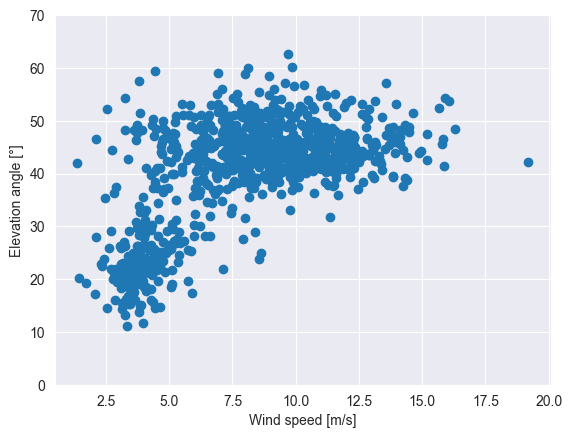

In [43]:
fig = plt.figure()
plt.scatter(df_all['wind_speed'], df_all['elevation'])
plt.ylabel('Elevation angle [°]')
plt.xlabel('Wind speed [m/s]')
plt.ylim(0,70)
fig.savefig('Plots/ScatterPlot.pdf')

In [44]:
#bins = np.arange(0, 91, bin_size)
bins = np.arange(0, 71, bin_size)
labels = [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(len(bins)-1)] ### pretty labels

# Elevation in bins
df_all['elev_bin'] = pd.cut(df_all['elevation'], bins=bins, labels=labels, include_lowest=True)

/var/folders/k6/y7fg0_p51yj9myt7l79bb1mc0000gn/T/ipykernel_64650/1255449222.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_all.groupby('elev_bin').size()


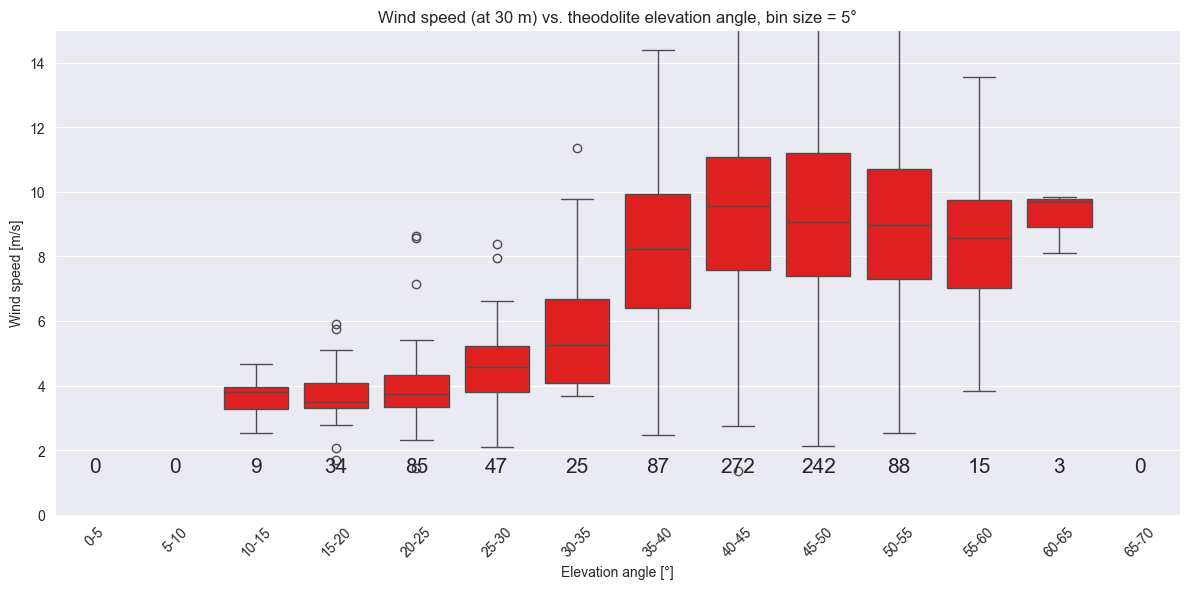

In [45]:
fig = plt.figure(figsize=(12,6))
sns.boxplot(x='elev_bin', y='wind_speed', data=df_all, color='r')

plt.xlabel('Elevation angle [°]')
plt.ylabel('Wind speed [m/s]')
plt.title(f'Wind speed (at {height_value} m) vs. theodolite elevation angle, bin size = {bin_size}°')
plt.xticks(rotation=45)
plt.ylim(0, 15)
#plt.xlim(0, 70)

# Show data points per bin
counts = df_all.groupby('elev_bin').size()
ax = plt.gca()
for i, bin_label in enumerate(labels):
    ax.text(i, 1.2, str(counts.get(bin_label,0)), ha='center', va='bottom', fontsize=15)

plt.tight_layout()
plt.show()
fig.savefig("Plots/boxplot_ws_elv_60m5deg_final_cut.pdf")


In [46]:
df_sorted = df_all.sort_values('wind_speed')
x = df_sorted['wind_speed'].values
y = df_sorted['elevation'].values

from scipy.interpolate import UnivariateSpline
spline = UnivariateSpline(x, y, s=1)
plt.scatter(x, y, alpha=0.5)
plt.plot(x, spline(x), color='red')
plt.show()

ValueError: x must be increasing if s > 0

# Scatter plot

To Do:
- tangent, largest change: divide into two regimes, fit two different trends, put it in one plot
- rename in legend: Data to theodolite data
- adjust the colors of the plot

a=46.143, b=0.510, x0=2.000
R²: 0.5045787952487868


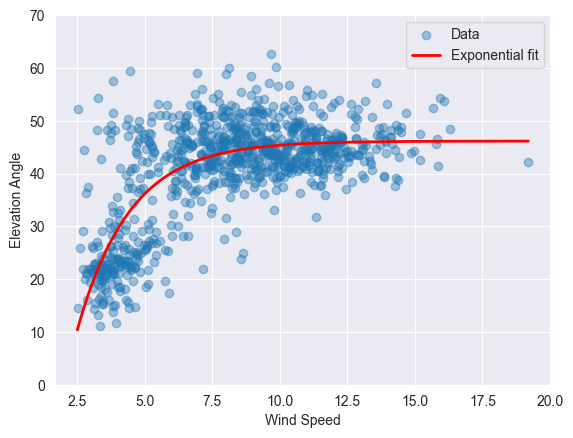

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

x = df_all['wind_speed'].to_numpy()
y = df_all['elevation'].to_numpy()

mask = np.isfinite(x) & np.isfinite(y) & (x > 2.5)
x, y = x[mask], y[mask]

# Exponentielles Modell
def exp_func(x, a, b, x0):
    return a * (1 - np.exp(-b * (x - x0)))

# Startwerte
p0 = [60, 0.5, 2.5]  # a≈60°, b≈0.5, x0≈2.5
bounds = ([0, 0, 2.0], [90, 10, 3.0])  # plausible Grenzen

popt, _ = curve_fit(exp_func, x, y, p0=p0, bounds=bounds)
a, b, x0 = popt
print(f"a={a:.3f}, b={b:.3f}, x0={x0:.3f}")

# Güte
y_hat = exp_func(x, *popt)
print("R²:", r2_score(y, y_hat))

# Plot
x_grid = np.linspace(2.5, x.max(), 400)
plt.scatter(x, y, alpha=0.4, label="Data")
plt.plot(x_grid, exp_func(x_grid, *popt), 'r', lw=2, label="Exponential fit")
#plt.axvline(2.5, color="gray", ls="--", lw=1)
plt.xlabel("Wind Speed")
plt.ylim(0,70)
plt.ylabel("Elevation Angle")
plt.legend()
plt.show()

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Data
x = df_all['wind_speed'].to_numpy()
y = df_all['elevation'].to_numpy()

# Filter
mask = np.isfinite(x) & np.isfinite(y) & (x > 2.5)
x, y = x[mask], y[mask]

# exponential model
def exp_func(x, a, b, x0):
    return a * (1 - np.exp(-b * (x - x0)))

# x grid
x_grid = np.linspace(2.5, x.max(), 400)

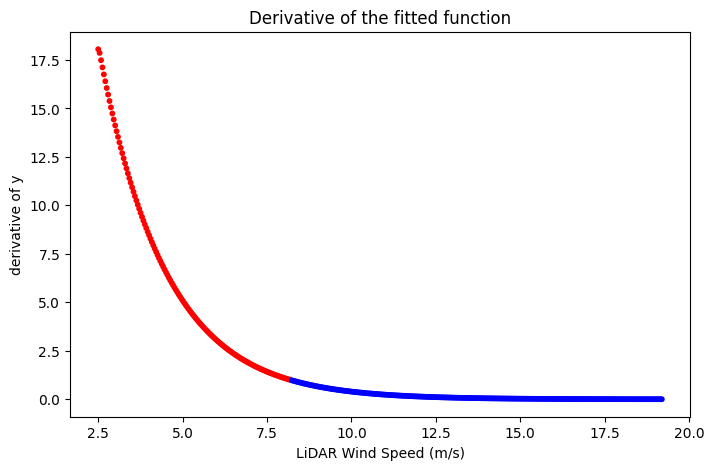

In [137]:
# derivative of the function
y_fit = exp_func(x_grid, *popt)
x_fit = x_grid
dy_dx = np.gradient(y_fit, x_fit) # derivative

threshold = 1.0
# threshold=2 means: if x increases by 1, y' increases by 2

# divide into sections
section2_y = y_fit[dy_dx <= threshold]  # section with slight increase
section1_y = y_fit[dy_dx > threshold]   # section with steep increase
section2_x = x_fit[dy_dx <= threshold]  # section with slight increase
section1_x = x_fit[dy_dx > threshold]   # section with steep increase

# mark sections in different colours
colour_threshold = np.where(dy_dx <= threshold, 'blue', 'red')

# Plot
fig2 = plt.figure(figsize=(8,5))
plt.scatter(x_fit, dy_dx, c=colour_threshold, s=10)
plt.xlabel('LiDAR Wind Speed (m/s)')
plt.ylabel('derivative of y')
plt.title('Derivative of the fitted function')
plt.show()
fig2.savefig("Plots/ScatterPlot_derivative.pdf")

a=46.143, b=0.510, x0=2.000
R²: 0.5045787686727888
Section 1 exp: a=46.143, b=0.510, x0=2.000
Section 1 R² exp: 1.0
Section 1 linear: y = 5.258 * x + 6.351
Section 2 exp: a=45.980, b=1.301, x0=6.000
Section 2 R² exp: 0.822119084963196
Section 2 linear: y = 0.122 * x + 44.125


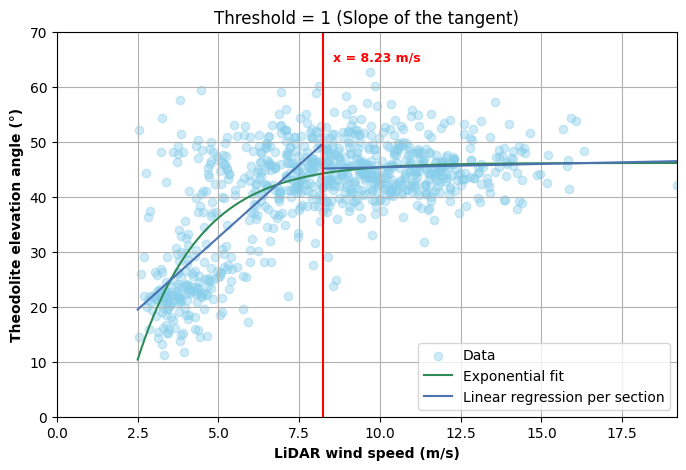

In [138]:
# the scatter plot here takes into account the altitude of the kite; so the shown wind speed is from the corresponding altitude level of the Lidar

# Starting values & boundaries
p0 = [60, 0.5, 2.5]                  # a≈60°, b≈0.5, x0≈2.5
bounds = ([0, 0, 2.0], [90, 10, 3.0])

# Curve Fit all data
popt, _ = curve_fit(exp_func, x_fit, y_fit, p0=p0, bounds=bounds)
a, b, x0 = popt
print(f"a={a:.3f}, b={b:.3f}, x0={x0:.3f}")
y_hat = exp_func(x, *popt) # R²
print("R²:", r2_score(y, y_hat))

# Curve Fit Section 1
p0_1 = [60, 2, 2.5]                  # a≈60°, b≈0.5, x0≈2.5
bounds_1 = ([0, 0, 1.5], [90, 5, 3.5])
popt_1, _ = curve_fit(exp_func, section1_x, section1_y, p0=p0_1, bounds=bounds_1)
a_1, b_1, x0_1 = popt_1
print(f"Section 1 exp: a={a_1:.3f}, b={b_1:.3f}, x0={x0_1:.3f}")
y_hat_1 = exp_func(section1_x, *popt_1) # R²
print("Section 1 R² exp:", r2_score(section1_y, y_hat_1))
#y_fit_1 = exp_func(section1_y, *popt_1)

coeffs_1 = np.polyfit(section1_x, section1_y, deg=1)  # Grad 1 = lineare Funktion
slope_1, intercept_1 = coeffs_1
print(f"Section 1 linear: y = {slope_1:.3f} * x + {intercept_1:.3f}")
y_fit_1 = np.polyval(coeffs_1, section1_x)  # berechnet y = slope*x + intercept

# Curve Fit Section 2
p0_2 = [60, 0.5, 7.5]                  # a≈60°, b≈0.5, x0≈2.5
bounds_2 = ([0, 0, 6], [90, 3, 15])
popt_2, _ = curve_fit(exp_func, section2_x, section2_y, p0=p0_2, bounds=bounds_2)
a_2, b_2, x0_2 = popt_2
print(f"Section 2 exp: a={a_2:.3f}, b={b_2:.3f}, x0={x0_2:.3f}")
y_hat_2 = exp_func(section2_x, *popt_2) # R²
print("Section 2 R² exp:", r2_score(section2_y, y_hat_2))
#y_fit_2 = exp_func(section2_y, *popt_2)

coeffs_2 = np.polyfit(section2_x, section2_y, deg=1)  # Grad 1 = lineare Funktion
slope_2, intercept_2 = coeffs_2
print(f"Section 2 linear: y = {slope_2:.3f} * x + {intercept_2:.3f}")
y_fit_2 = np.polyval(coeffs_2, section2_x)  # berechnet y = slope*x + intercept


# Plot
fig1 = plt.figure(figsize=(8,5), facecolor='white')
plt.style.use('default')
plt.grid(True)
plt.scatter(x, y, alpha=0.4, label="Data", color="skyblue") # or use LiDAR color="#4C72B0"

fit_label = f"y = {a:.1f} * (1 - exp(-{b:.3f}*(x - {x0:.2f})))"
#plt.plot(x_grid, exp_func(x_grid, *popt), lw=2, label=fit_label, color="seagreen")
plt.plot(section1_x, section1_y, color="seagreen", label= 'Exponential fit')
plt.plot(section2_x, section2_y, color="seagreen")
plt.plot(section1_x, y_fit_1, color='#4C72B0', label='Linear regression per section')
plt.plot(section2_x, y_fit_2, color='#4C72B0')
plt.xlabel("LiDAR wind speed (m/s)", fontweight='bold')
plt.ylabel("Theodolite elevation angle (°)", fontweight='bold')
plt.ylim(0, 70)
plt.xlim(0,section2_x[-1])
plt.legend()
plt.axvline(section2_x[0], color='red')
ymin, ymax = plt.ylim()
x_offset = 0.3  # Verschiebung nach rechts
plt.text(section2_x[0] + x_offset, ymax*0.95, f"x = {section2_x[0]:.2f} m/s",
         color='red', ha='left', va='top', fontweight='bold', fontsize=9)
plt.title(f"Threshold = {threshold:.0f} (Slope of the tangent)")
plt.show()
fig1.savefig("Plots/ScatterPlot_Funct_1.pdf", facecolor='white') #, edgecolor='white'

# Trash

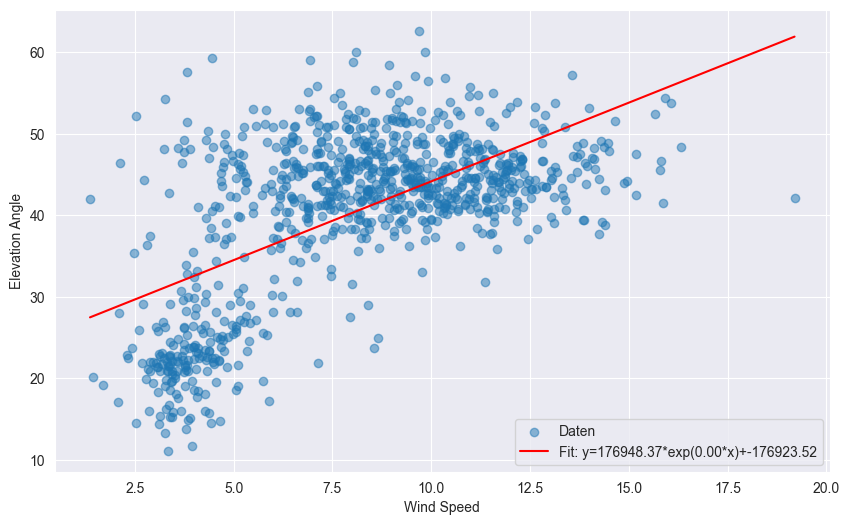

In [149]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Beispiel: Daten (x = Wind Speed, y = Elevation Angle)
# Hier musst du deine echten Datenarrays einfügen!
x_data = df_all['wind_speed'].to_numpy()  # Wind Speed
y_data = df_all['elevation'].to_numpy()  # Elevation Angle

# Exponentielle Funktion definieren
def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

# x_data und y_data bereinigen: NaN / Inf entfernen
mask = np.isfinite(x_data) & np.isfinite(y_data)
x_clean = x_data[mask]
y_clean = y_data[mask]

# Curve Fit
#params, covariance = curve_fit(exp_func, x_clean, y_clean, p0=(1, 0.1, 1))
params, covariance = curve_fit(exp_func, x_clean, y_clean, p0=(1, 0.01, np.mean(y_clean)), maxfev=10000)

a, b, c = params

# Fit-Kurve erstellen
x_fit = np.linspace(min(x_data), max(x_data), 500)
y_fit = exp_func(x_fit, a, b, c)

# Plotten
plt.figure(figsize=(10,6))
plt.scatter(x_data, y_data, alpha=0.5, label="Daten")
plt.plot(x_fit, y_fit, 'r-', label=f'Fit: y={a:.2f}*exp({b:.2f}*x)+{c:.2f}')
plt.xlabel("Wind Speed")
plt.ylabel("Elevation Angle")
plt.legend()
plt.show()
